# Swin Transformer: Hierarchical Vision Transformer using Shifted Windows¶

## Research Paper Link : https://arxiv.org/pdf/2103.14030

## Github Link : https://github.com/yogeshbawankar/PyTorch-Collection¶

Loading CIFAR-10 dataset...


100%|██████████| 170M/170M [00:04<00:00, 39.4MB/s]


Classes: ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Training started...
Epoch 1/5 | Loss: 1.7380 | Acc: 35.23%
Epoch 2/5 | Loss: 1.5278 | Acc: 44.34%
Epoch 3/5 | Loss: 1.4338 | Acc: 47.91%
Epoch 4/5 | Loss: 1.3703 | Acc: 50.14%
Epoch 5/5 | Loss: 1.3163 | Acc: 52.56%
Training finished.
Test Accuracy: 51.13%


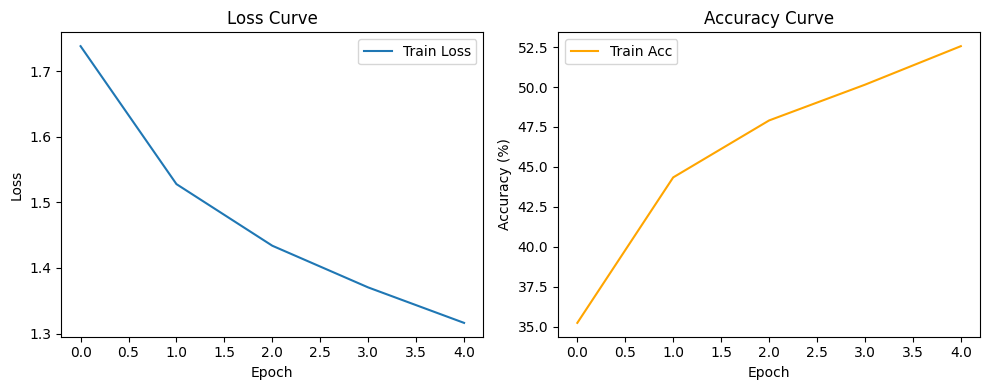

In [1]:
# ----------------------------------------------------------
# Simple Swin Transformer Demo in PyTorch
# ----------------------------------------------------------
# This script demonstrates an end-to-end workflow for training
# a simplified Swin Transformer on CIFAR-10.
# It is designed for TEACHING PURPOSES: clear, minimal, and well-commented.
# ----------------------------------------------------------

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# ==========================================================
# 1. Load CIFAR-10 dataset
# ==========================================================
print("Loading CIFAR-10 dataset...")

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

train_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=True, download=True, transform=transform
)
test_dataset = torchvision.datasets.CIFAR10(
    root='./data', train=False, download=True, transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

classes = train_dataset.classes
print("Classes:", classes)

# ==========================================================
# 2. Define Swin Transformer Components
# ==========================================================

# Helper: Patch Partition + Embedding
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, embed_dim=96, patch_size=4):
        super().__init__()
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        # Input shape: (B, C, H, W)
        x = self.proj(x)   # (B, embed_dim, H/patch, W/patch)
        x = x.flatten(2).transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

# Window-based Multi-Head Self Attention (simplified)
class WindowAttention(nn.Module):
    def __init__(self, dim, num_heads=3):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim, num_heads=num_heads, batch_first=True)

    def forward(self, x):
        # x: (B, N, C)
        attn_out, _ = self.attn(x, x, x)
        return attn_out

# Swin Block (regular + shifted window simulated)
class SwinBlock(nn.Module):
    def __init__(self, dim, num_heads=3, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(dim)
        self.attn = WindowAttention(dim, num_heads=num_heads)
        self.norm2 = nn.LayerNorm(dim)
        self.mlp = nn.Sequential(
            nn.Linear(dim, int(dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(dim * mlp_ratio), dim)
        )

    def forward(self, x):
        # Attention + residual
        x = x + self.attn(self.norm1(x))
        # MLP + residual
        x = x + self.mlp(self.norm2(x))
        return x

# Simple Swin Transformer (Tiny)
class SimpleSwin(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.embed = PatchEmbedding(in_channels=3, embed_dim=96, patch_size=4)

        # One "stage" of Swin blocks (for demo, just 2 blocks)
        self.stage1 = nn.Sequential(
            SwinBlock(dim=96, num_heads=3),
            SwinBlock(dim=96, num_heads=3)
        )

        # Classification head
        self.norm = nn.LayerNorm(96)
        self.fc = nn.Linear(96, num_classes)

    def forward(self, x):
        x = self.embed(x)          # (B, N, C)
        x = self.stage1(x)         # apply Swin blocks
        x = self.norm(x)           # normalize
        x = x.mean(dim=1)          # global average pooling over patches
        x = self.fc(x)             # classification
        return x

# ==========================================================
# 3. Train the Model
# ==========================================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleSwin(num_classes=10).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

num_epochs = 5
train_loss_history, train_acc_history = [], []

print("Training started...")
for epoch in range(num_epochs):
    running_loss, correct, total = 0.0, 0, 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    train_loss_history.append(epoch_loss)
    train_acc_history.append(epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.2f}%")

print("Training finished.")

# ==========================================================
# 4. Evaluate on Test Set
# ==========================================================
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_acc = 100. * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")

# ==========================================================
# 5. Visualization
# ==========================================================
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(train_loss_history, label="Train Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.title("Loss Curve"); plt.legend()

plt.subplot(1,2,2)
plt.plot(train_acc_history, label="Train Acc", color='orange')
plt.xlabel("Epoch"); plt.ylabel("Accuracy (%)"); plt.title("Accuracy Curve"); plt.legend()

plt.tight_layout()
plt.show()


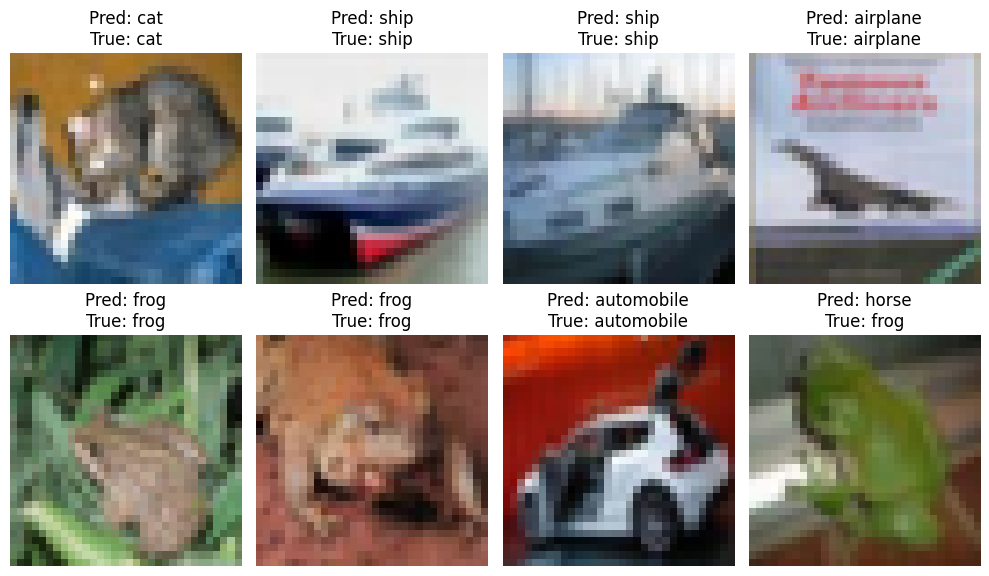

In [2]:
# ==========================================================
# 6. Make Predictions and Visualize
# ==========================================================
import numpy as np

# Get some test images
dataiter = iter(test_loader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Run the model on these images
outputs = model(images)
_, predicted = outputs.max(1)

# Show images with predicted & true labels
def imshow(img, title):
    img = img / 2 + 0.5  # unnormalize (since we normalized earlier)
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

plt.figure(figsize=(10, 6))
for idx in range(8):  # visualize 8 images
    plt.subplot(2, 4, idx+1)
    imshow(images[idx].cpu(),
           f"Pred: {classes[predicted[idx]]}\nTrue: {classes[labels[idx]]}")
plt.tight_layout()
plt.show()

In [3]:

model

SimpleSwin(
  (embed): PatchEmbedding(
    (proj): Conv2d(3, 96, kernel_size=(4, 4), stride=(4, 4))
  )
  (stage1): Sequential(
    (0): SwinBlock(
      (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (attn): WindowAttention(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
      )
      (norm2): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (mlp): Sequential(
        (0): Linear(in_features=96, out_features=384, bias=True)
        (1): GELU(approximate='none')
        (2): Linear(in_features=384, out_features=96, bias=True)
      )
    )
    (1): SwinBlock(
      (norm1): LayerNorm((96,), eps=1e-05, elementwise_affine=True)
      (attn): WindowAttention(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=96, out_features=96, bias=True)
        )
      )
      (norm2): LayerNorm((96,), eps=1e-05, elementwise_